In [1]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_name = glob.glob('./pg_ressults_reuse/*')
all_ressults = []
counter = 0
for i in file_name:
    all_ressults.append(i)
all_ressults.sort()

for ressult in all_ressults:
    print(f'index: {counter}, {ressult}')
    counter += 1

print(f'number of models: {len(all_ressults)}')

index: 0, ./pg_ressults_reuse/reuse_1.json
index: 1, ./pg_ressults_reuse/reuse_1_changed_value.json
index: 2, ./pg_ressults_reuse/reuse_2.json
index: 3, ./pg_ressults_reuse/reuse_2_changed_value.json
index: 4, ./pg_ressults_reuse/reuse_3.json
index: 5, ./pg_ressults_reuse/reuse_4.json
index: 6, ./pg_ressults_reuse/reuse_4_changed_value.json
index: 7, ./pg_ressults_reuse/reuse_5.json
number of models: 8


In [3]:
file_path = all_ressults[3] #2-9
# DENNE FYNKER: index 4, ./pg_ressults/try_to_find_base/new_2_val_64_pg_128_lr_clip_2026.24644713861755.json
'''
notes

changing network size dident have any noticbale effect

best ressults:
    - ./pg_ressults/policy_two_value_two/pg_Adam_0.001_val_0.001_40_3.047289364372708.json
    - pg_ressults/policy_two_value_two/pg_Adam_0.0001_val_0.0001_40_3.083129484271177.json
    - /policy_two_value_two/pg_Adam_0.01_val_1e-05_40_3.2075443048653938.json


2: Value: 0.001 nbetter than 0.01
policy,value one layer:
    num: 6: best so far: policy: 1e-5, value 0.01, some movment in policy
    num 7: policy 0.1, value 0.001, les variation for policy
    num 8: 100 modeler, policy 0.1 mindre variasjon
    
policy_one_value_two:
- not notibale good ressults, one where able to have some pg traing. I think if either value function have
a high lr or the policy function have one they will break each other.

policy_two_value_two: (is able to beat random but not converge this far)
    pg lr: 0.01, value 0.001: unstable traing for pg, super
        fast raining for value, notable to converge, but get some higher reward in the end.
        
    pg lr: 0.1, value 0.01, less stable then the results above?!?!?!, 
    
    pg: lr: 0.01, value 0.001, notiable changes, but not converges, I will do more experiemnts her
    
    (loock at batch size for next analyses.)
    
    prøv: pg: 0.01, val: 0.001, 1e-5, /pg_ressults/policy_two_value_two/policy_gradient_Adam_0.01_2.5564491305377133.json
    
    policy 0.001, val 0.001
    
    I feel that less batches give better reard over time vs bigger batches, but should have more then 3,
    I'm adding gamma so earlier mistakes wont have a huge effect.
    
    
Hvirker som value burde være høy for å trene, hjelper å stabilisere policy

'''

def scatter_model_used(model_info, num_models, num_trials):
    counter = 0
    used_list = []
    
    for _ in range(num_models):
        used_list.append(np.full(num_trials, -10))
    
    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[counter][used] = counter

        counter += 1
        
    counter_list = range(num_trials)
    
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0, int(round(num_models * 1.05)))
    for i in range(num_models):
        plt.scatter(counter_list, used_list[i])
    plt.show()
    
def plot_loss(policy_list, title):
    plt.figure(figsize=(16, 10))
    #plt.ylim(0,1)
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(title, fontsize=30)

    plt.plot(policy_list,'m' ,linewidth=3, label='Loss')
    plt.legend(loc='best', fontsize=15)
    plt.show()

#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses
    
def score_graph(scores, iou_scores, means, model_info, batch_size, list_length, num_models):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    
    
    print(f' Avg score pr model: {model_score_avg}')
    
    avg = np.array([model_score_avg for i in range(list_length)])
    avg_explore = np.array([0.519 for i in range(list_length)]) # 0.5186551321699284
    #avg_iou = np.array([0.0185 for i in range(list_length)]) #0.0185 0.13364625770486935
    avg_iou = np.array([0.101 for i in range(list_length)]) #0.10119017522614594
    
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(avg_iou, 'y--', label='Average IoU')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='pixel score')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='iou score')
    plt.legend(loc='best', fontsize=15)
    plt.show()

In [4]:
with open(file_path) as reader:
    model_info = json.load(reader)



In [5]:
print('------------------------ MODEL INFO START ------------------------')
print(f'Policy lr: {model_info["policy_lr"]}, Policy clip: {model_info["policy_clip"]}, optimizer: {model_info["optimizer"]}')
print(f'Value lr: {model_info["value_lr"]}, Value clip: {"value_clip"}')
print(f'Reward ekspontential: {model_info["reward_exponential"]}, Reward mulitiplikation: {model_info["reward_multi"]}, batch size: {model_info["batch_size"]}, box size: {model_info["box_size"]}, gamma: {model_info["gamma"]}')



------------------------ MODEL INFO START ------------------------
Policy lr: 0.0001, Policy clip: 3, optimizer: Adam
Value lr: 0.0001, Value clip: value_clip
Reward ekspontential: 3, Reward mulitiplikation: 13, batch size: 10, box size: 5, gamma: 1


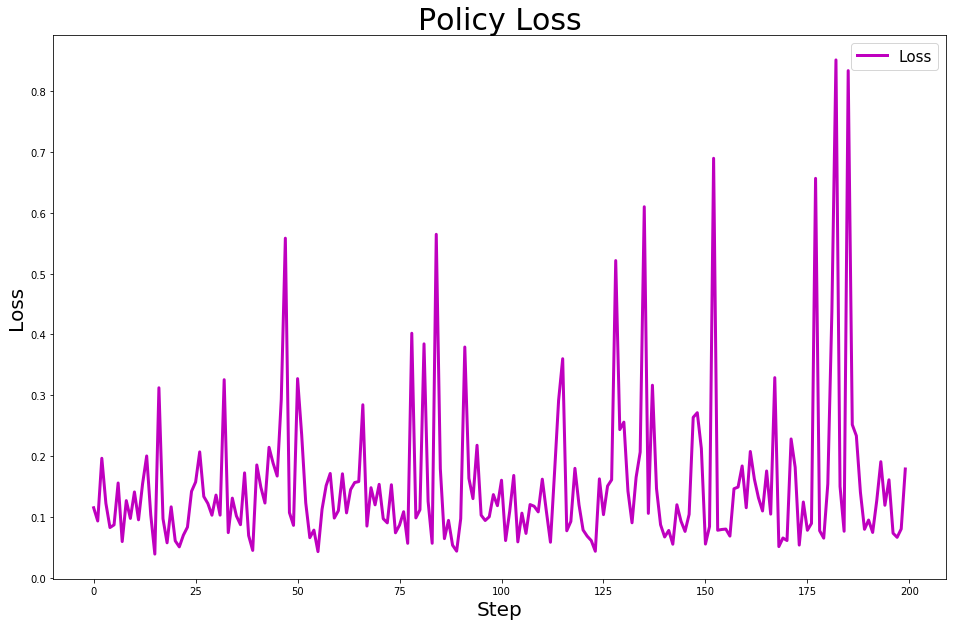

In [6]:
plot_loss(model_info['policy_loss'], 'Policy Loss')

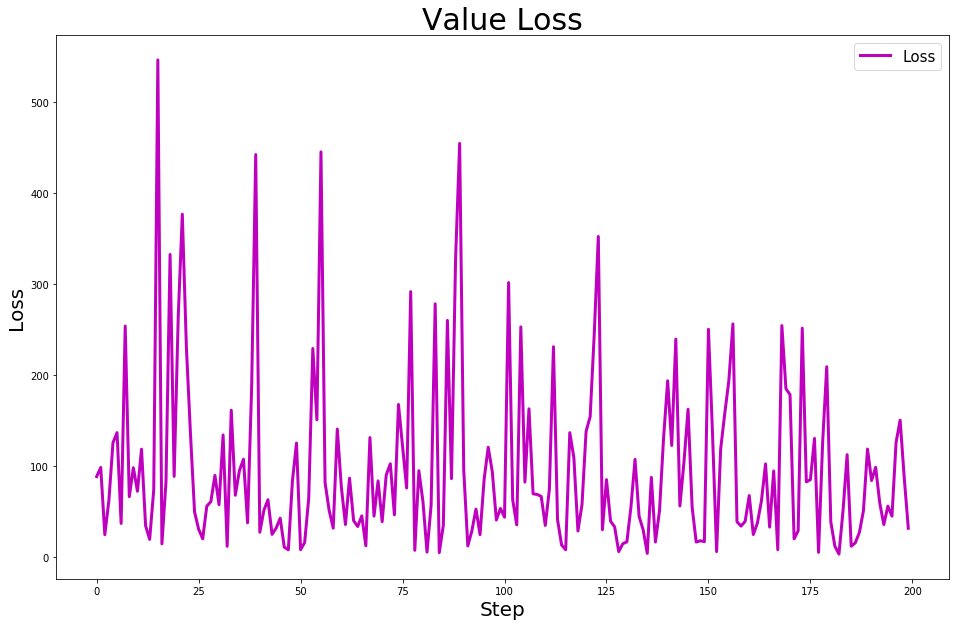

In [7]:
plot_loss(model_info['value_loss'], 'Value Loss')

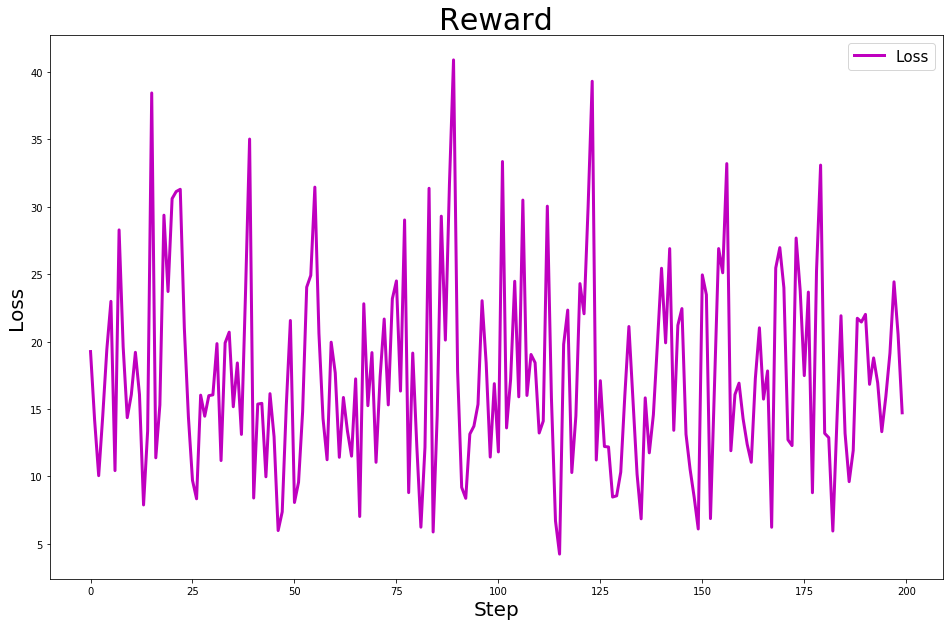

In [8]:
plot_loss(model_info['reward_list'], 'Reward')

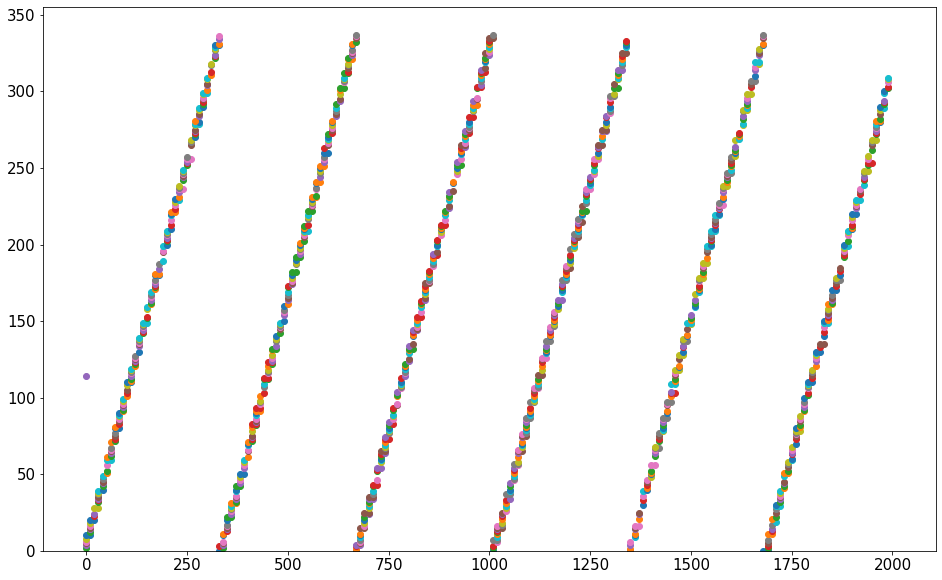

In [9]:
scatter_model_used(model_info['model_info'], model_info['num_models'], model_info['num_trials'])

 Avg score pr model: 0.46257754065627377


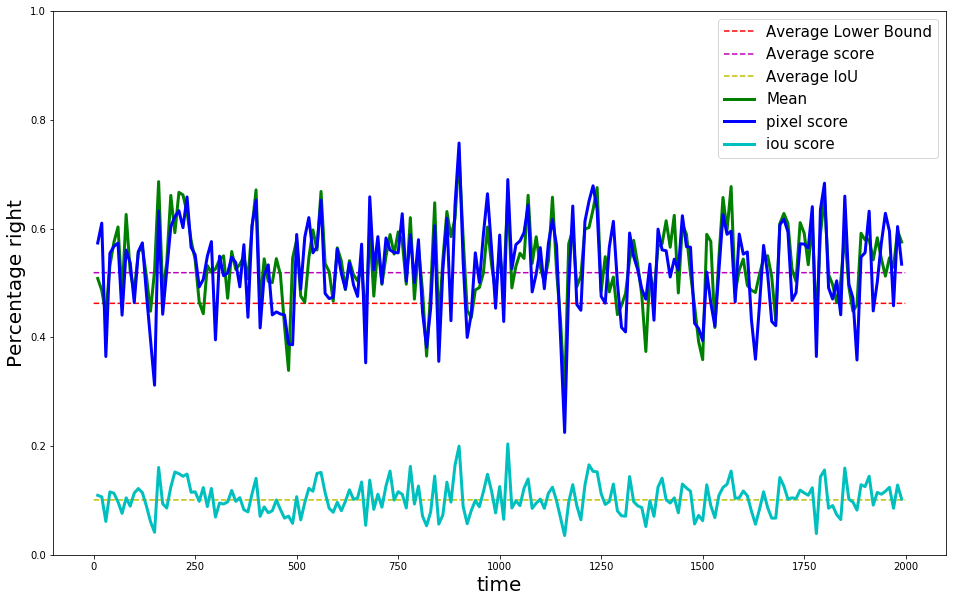

In [10]:
score_graph(model_info['pixel_scores'], model_info['iou_scores'], model_info['mean_values'], model_info['model_info'], batch_size=model_info['batch_size'], list_length=model_info['num_trials'], num_models=model_info['num_models'])

In [11]:
for key in model_info.keys():
    print(key)

policy_lr
value_lr
policy_clip
value_clip
reward_exponential
reward_multi
batch_size
box_size
gamma
reward_list
policy_loss
value_loss
optimizer
num_models
num_trials
iou_scores
pixel_scores
mean_values
std_values
model_info


In [12]:
print(f'Iou score: {np.array(model_info["iou_scores"]).mean()}')
print(f'Pixel score: {np.array(model_info["pixel_scores"]).mean()}')
print(f'Mean value: {np.array(model_info["mean_values"]).mean()}')
print(f'Std value: {np.array(model_info["std_values"]).mean()}')

lower_bound = np.array(model_info['mean_values']).mean() - np.array(model_info['std_values']).mean()
print(f'Lower bound: {lower_bound}')

Iou score: 0.1039331529778291
Pixel score: 0.5275573909505208
Mean value: 0.5366898908540606
Std value: 0.07033889653837264
Lower bound: 0.46635099431568794


## 